# Multiple Linear Regression Lab

This lab uses data from Edelman, Benjamin, Michael Luca, and Dan Svirsky. 2017. "[Racial Discrimination in the Sharing Economy: Evidence from a Field Experiment](https://www.aeaweb.org/articles?id=10.1257/app.20160213)." *American Economic Journal: Applied Economics* 9 (2): 1-22. 

## Context

1. Research Question: Do Airbnb hosts respond differently to requests from guests based on race/ethnicity or sex?

2. The data is from a randomized experiment on Airbnb that was executed in July 2015 for properties in Baltimore, Dallas, Los Angeles, and Washington, DC.

3. Researchers created 20 fake Airbnb guest accounts that were identical in all respects except for the race/ethnicity and sex of the account holder. The sex and race/ethnicity of guests was signaled through their names.

4. Researchers sent inquiries to each host from one of the randomly selected fake accounts. The inquiries asked about availability during a specific weekend in September.

5. Researchers tracked responses to the inquiry for 30 days after the request.

## Stata Initialization

- Set directory and log file name 
- Install `reghdfe` - this command allows for many fixed effects and multiple levels of clustering.
- Notes: Stata has built-in commands to handle fixed effects (`areg`; `xtreg, fe`), but at this point, I still recommend using `reghdfe`.

In [1]:
* DIRECTORY SETUP
cd "C:\Users\michael.baker\Documents\ss368\ss368-private\problem_sets\ps4-mlr-lab"

* setup log (see do file shell)

* install reghdfe (see do file shell)

C:\Users\michael.baker\Documents\ss368\ss368-private\problem_sets\ps4-mlr-lab


## Summary Statistics (Table 1) 
### 1. Import the raw data: `airbnb_mlr_lab.dta` and drop Tampa and Atlanta.

In [2]:
use "./raw_dta/airbnb_mlr_lab.dta", clear

* drop Tampa and Atlanta 
drop if inlist(city,"Tampa","Atlanta")
*** note: the above is equivalent to: drop if city=="Tampa" | city=="Atlanta" // but inlist() is easier 

tab city,m 



(1,164 observations deleted)


       city |      Freq.     Percent        Cum.
------------+-----------------------------------
  Baltimore |        347        5.43        5.43
     Dallas |        420        6.57       12.00
Los-Angeles |      3,913       61.24       73.24
   St-Louis |        151        2.36       75.60
 Washington |      1,559       24.40      100.00
------------+-----------------------------------
      Total |      6,390      100.00


### 2. Create indicators for each category of host race/ethnicity and sex using `host_race` and `host_sex`. Count missing values as a separate category. Create indicators for each category of guest race/ethnicity and sex using `guest_race` and `guest_sex`.

In [3]:
* create indicators for host race
gen host_race_black = host_race=="BLACK"
gen host_race_white = host_race=="WHITE"
gen host_race_hisp = host_race=="HISPANIC"
gen host_race_asian = host_race=="ASIAN"
gen host_race_mult = host_race=="MULTIPLE"  
gen host_race_msg = missing(host_race)
* note: the last line is equivalent to: gen host_race_msg = host_race=="" // but the missing() functions works for string and numeric variables

* create indicators of host sex
gen host_sex_male = host_sex=="M"
gen host_sex_female = host_sex=="F"
gen host_sex_msg = missing(host_sex)

* create indicators for guest race
gen guest_race_black = guest_race=="black"
gen guest_race_white = guest_race=="white" 

* create indicators for guest race/sex
gen guest_sex_male = guest_sex=="male" 
gen guest_sex_female = guest_sex=="female"

### 3. Create a simple table with summary statistics using the `tabstat` command. Report the mean (`mean`), standard deviation (`sd`), min (`min`), 25th percentile (`p25`), 75th percentile (`p75`), max (`max`), and no. of observations (`N`) for each variable. Include the following categories: 
- Demographics of hosts: indicators for 
- Listing characteristics: price (`price`), no. of bedrooms (`bedrooms`), no. of bathrooms (`bathrooms`), and no. of reviews (`number_of_reviews`)
- Host Activity Measures: indicators for having multiple listings (`multiple_listings`) and having had any Black guests (`any_black_guest`)
- Location Characteristics: Airbnb listings in the Census tract (`tract_listings`), Share of the Census tract population that is Black (`black_proportion`). 

Confirm that your results match Table 1 from the paper (the max no. of obs will be 6,390 instead of 6,392. Do not worry about this). 

In [4]:
* host demographic characteristics
local host_demo_char host_race_white host_race_black host_race_msg host_sex_female host_sex_male host_sex_msg 

* listing characteristics
local listing_char price bedrooms bathrooms number_of_reviews

* additional host characteristics
local host_char multiple_listings any_black_guest

* location characteristics
local location_char tract_listings black_proportion

* note: linesize adjusts table width for proper display
set linesize 200

di "Table 1 Replication:"
tabstat `host_demo_char' `listing_char' `host_char' `location_char', stats(mean sd min p25 p75 max N) c(stats) varwidth(20)

sum price,d







Table 1 Replication:


            Variable |      Mean        SD       Min       p25       p75       Max         N
---------------------+----------------------------------------------------------------------
     host_race_white |  .6342723  .4816713         0         0         1         1      6390
     host_race_black |  .0782473  .2685813         0         0         0         1      6390
       host_race_msg |  .1733959  .3786188         0         0         0         1      6390
     host_sex_female |  .3765258  .4845522         0         0         1         1      6390
       host_sex_male |  .2982786  .4575382         0         0         1         1      6390
        host_sex_msg |  .3251956  .4684846         0         0         1         1      6390
               price |  181.1081  1280.228        10        75       175    100000      6302
            bedrooms |  3.177027  2.264917         1         2         4        16      6242
           bathrooms |  3.169292   2.2640

### 4. Briefly discuss any concerns about the data that would affect how you complete the rest of the analysis. 

- Answers will vary. Some discussion of issues with missing values. Potential discussion of outliers with price, number of reviews, etc. 

- What could we do about missing price information? Drop observations or impute missing. Both have downsides. 

- What could we do about outliers? Take natural log or windsorize. 

### 5. For each variable, conduct a two-sample $t$-test for the difference in means based on the treatment (`guest_black==1`). Use the `ttest` command. Confirm that your results match Table 1 from the paper (the max no. of obs will be 6,390 instead of 6,392, do not worry about this).

In [5]:
foreach var in `host_demo_char' `listing_char' `host_char' `location_char' {
	di "-----------------------------"
	di "Two-Sample t-test - `var':"
	* conduct t-test // qui is short for quietly, which suppresses output
	qui ttest `var', by(guest_race_white)
    * display key values 
	di "Raw Difference: `r(mu_diff)'"
	di "t-stat: `r(t)'"
	di "p-value: `r(p)'"
	* note: we can also test for a two-sample difference in means using regression:
    di "Regression Difference in Means:"
    reg `var' guest_race_black
	di "-----------------------------"
}


-----------------------------
Two-Sample t-test - host_race_white:
Raw Difference: -.0171680710770741
t-stat: -1.424704469692247
p-value: .1542914975993785
Regression Difference in Means:

      Source |       SS           df       MS      Number of obs   =     6,390
-------------+----------------------------------   F(1, 6388)      =      2.03
       Model |  .470848455         1  .470848455   Prob > F        =    0.1543
    Residual |  1481.82352     6,388  .231969868   R-squared       =    0.0003
-------------+----------------------------------   Adj R-squared   =    0.0002
       Total |  1482.29437     6,389  .232007257   Root MSE        =    .48163

----------------------------------------------------------------------------------
 host_race_white | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-----------------+----------------------------------------------------------------
guest_race_black |  -.0171681   .0120503    -1.42   0.154    -.0407906    .0064545
   

### 6. Briefly discuss whether the evidence in consistent with random assignment of guest race/ethnicity to hosts. 

- The evidence is consistent with random assignment. The race of the guest is unrelated to host or listing characteristics. 

***Commit Changes to GitHub.*** Include a specific commit message that describes your updates.

## Main Results (Table 2)

### 1. Estimate the gap in response rates by guest race by estimating regressions of the form: 

$$Y_i = \alpha + \beta D_i  + X_i' \gamma + u_i$$

Where $Y_i \equiv \mathbf{1}\{\text{Yes Response}\}$ (`yes`) and $D_i \equiv \mathbf{1}\{\text{Guest Race is Black}\}$ (`guest_race_black`). Cluster standard errors at the level of name-by-city (`name_by_city`) by adding `vce(cluster name_by_city)` to your regression. 

- Col. 1: no controls - $X_i$ is omitted
- Col. 2: add separate indicators for whether the host is Black and whether the host is male
- Col. 3: add `multiple_listings`, `shared_property`, `ten_reviews`, and `log_price`. Note: you will need to generate `log_price` from `price`.

Confirm your results match Table 2 from the paper. 

In [6]:
*---------------------------------------------------------
* CREATE MAIN RESULTS TABLE (TABLE 2)
*---------------------------------------------------------

* note: dv is missing for 157 obs, driving discrepancy in no. of obs between sumstats and regression tables 

* create log price variable
gen log_price = ln(price)

*** col. 1 - no controls
di "Col. 1 Regression"
reg yes guest_race_black, vce(cluster name_by_city)

***** calc. depvar mean for white guests
qui sum yes if e(sample) & guest_race_white==1 
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

*** calc. percentage effect 
local percentage_effect = string(round(((_b[guest_race_black]/`r(mean)')*100),0.01), "%6.2f")
di "Percentage Effect: " `percentage_effect' "%"

*** col. 2 - controlling for host race and gender 
di "Col. 2 Regression"
reg yes guest_race_black host_race_black host_sex_male, vce(cluster name_by_city)

***** calc. depvar mean for white guests 
qui sum yes if e(sample) & guest_race_white==1 
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

*** calc. percentage effect 
local percentage_effect = string(round(((_b[guest_race_black]/`r(mean)')*100),0.01), "%6.2f")
di "Percentage Effect: " `percentage_effect' "%"

*** col. 3 - controlling for other characteristics 
di "Col. 3 Regression"
reg yes guest_race_black host_race_black host_sex_male multiple_listings shared_property ten_reviews log_price, vce(cluster name_by_city)

***** calc. depvar mean for white guests 
qui sum yes if e(sample) & guest_race_white==1 
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

*** calc. percentage effect 
local percentage_effect = string(round(((_b[guest_race_black]/`r(mean)')*100),0.01), "%6.2f")
di "Percentage Effect: " `percentage_effect' "%"


(88 missing values generated)

Col. 1 Regression


Linear regression                               Number of obs     =      6,235
                                                F(1, 103)         =      21.88
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0064
                                                Root MSE          =     .49582

                             (Std. err. adjusted for 104 clusters in name_by_city)
----------------------------------------------------------------------------------
                 |               Robust
             yes | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-----------------+----------------------------------------------------------------
guest_race_black |  -.0796129   .0170206    -4.68   0.000    -.1133692   -.0458566
           _cons |   .4877894   .0119383    40.86   0.000     .4641126    .5114662
--------------

### 2. What is the key identifying assumption for $\hat{\beta}$ to have a causal interpretation?

- The key assumption is that the race of the guest (the probability that a guest is Black) must be unrelated to any unobserved factors in $u_i$ (i.e., the zero conditional mean must hold). Since this is an RCT, the researchers controlled assignment to treatment. This fact, combined with the evidence in Table 1, gives us confidence that this assumption is likely to hold. 

### 3. Interpret the coefficient estimate in col. 1, discussing the practical and statistical significance of the result. 

- Black guests were approximately 8 p.p. less likely to receive a positive response. This result is statistically significant at any conventional level and practically significant, representing a 16.3\% decrease from the mean. 

### 4. How does your estimate of $\beta$ change as controls are added in col.'s 2 and 3? How does this relate to the identifying assumptions? 

- $\hat{\beta}$ is relatively stable across specifications. This ought to be the case given that we have already seen the treatment is not systematically related to any host or location characteristics in Table 1. 

### 5. What do we call a model with an indicator as the dependent variable? What are some of the benefits and shortcomings of estimating this model by OLS? 

- This is a linear probability model. The benefit of estimating this model by OLS is that it is straightforward to apply regression tools. We must be careful to use heteroskedasticity-robust standard errors. We also need to understand that we may be predictions outside of $[0,1]$.

### 6. How much does the LPM differ from Logit/Probit?
- The code below estimates the Table 2, col. 1 specification by OLS (LPM), Logit, and Probit. In this instance the LPM does a good job of estimating the average partial effect (APE).

In [7]:
* LPM
reg yes guest_race_black, vce(cluster name_by_city)
local ape_lpm = round(_b[guest_race_black],0.001)

* Logistic Regression
logit yes guest_race_black, vce(cluster name_by_city)

* Take average marginal effects
margins, dydx(*) 
local ape_logit = round(r(b)[1,1],0.001)

* Probit Regression
probit yes guest_race_black, cluster(name_by_city)

* Take average marginal effects
margins, dydx(*) 
local ape_probit = round(r(b)[1,1],0.001)

* comparison of results
di "Avg. Partial Effect, LPM: " `ape_lpm'
di "Avg. Partial Effect, Logit: " `ape_logit'
di "Avg. Partial Effect, Probit: " `ape_probit'



Linear regression                               Number of obs     =      6,235
                                                F(1, 103)         =      21.88
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0064
                                                Root MSE          =     .49582

                             (Std. err. adjusted for 104 clusters in name_by_city)
----------------------------------------------------------------------------------
                 |               Robust
             yes | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-----------------+----------------------------------------------------------------
guest_race_black |  -.0796129   .0170206    -4.68   0.000    -.1133692   -.0458566
           _cons |   .4877894   .0119383    40.86   0.000     .4641126    .5114662
----------------------------------------------------------------

### 7. Note on Standard Errors in the LPM

- We know the LPM violates constant variance, so we have to use robust SE's at a minimum. The authors cluster SE's at the level of name-by-city. In brief, this allows the regression errors to be correlated within a name by city group (e.g., Tanisha in LA). For inference, the number of clusters, not the number of observations, is what matters. 

- In this case there isn't much difference between the homoskedastic and heteroskedasticity-robust standard errors, but we do see that clustering makes a difference (increase in SE from 0.013 to 0.017). 

In [8]:
* assuming constant variance
reg yes guest_race_black

* heteroskedasticity-robust
reg yes guest_race_black, r

* cluster-robust (as in paper)
reg yes guest_race_black, vce(cluster name_by_city)



      Source |       SS           df       MS      Number of obs   =     6,235
-------------+----------------------------------   F(1, 6233)      =     40.18
       Model |  9.87840926         1  9.87840926   Prob > F        =    0.0000
    Residual |  1532.29384     6,233  .245835688   R-squared       =    0.0064
-------------+----------------------------------   Adj R-squared   =    0.0062
       Total |  1542.17225     6,234  .247380856   Root MSE        =    .49582

----------------------------------------------------------------------------------
             yes | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-----------------+----------------------------------------------------------------
guest_race_black |  -.0796129   .0125592    -6.34   0.000    -.1042333   -.0549925
           _cons |   .4877894     .00883    55.24   0.000     .4704796    .5050992
----------------------------------------------------------------------------------


Linear regression      

### 8. Add city fixed effects to the model in col. 3. Show that you get the same result whether using `reg` or `reghdfe`. 

In [9]:
* make a numeric city variable
encode city, gen(city_num)
 
fre city_num 
* if you do not have fre installed, type: ssc install fre. fre allows you to see the numerical value and label side-by-side

* METHOD 1: insert the fixed effects directly - okay if there aren't very many OR if we care about the coefficients 

*** select the "base" city (Dallas) - o.w. Stata will select the base city for you 
fvset base 2 city_num 

*** estimate regression 
reg yes guest_race_black i.city_num, vce(cluster name_by_city)

* METHOD 2: absorb - if there are many fixed effects or if you don't care about the coefficients 
reghdfe yes guest_race_black, absorb(city_num) vce(cluster name_by_city)




city_num
-------------------------------------------------------------------
                      |      Freq.    Percent      Valid       Cum.
----------------------+--------------------------------------------
Valid   1 Baltimore   |        347       5.43       5.43       5.43
        2 Dallas      |        420       6.57       6.57      12.00
        3 Los-Angeles |       3913      61.24      61.24      73.24
        4 St-Louis    |        151       2.36       2.36      75.60
        5 Washington  |       1559      24.40      24.40     100.00
        Total         |       6390     100.00     100.00           
-------------------------------------------------------------------



Linear regression                               Number of obs     =      6,235
                                                F(5, 103)         =       5.47
                                                Prob > F          =     0.0002
                                                R-squared         = 

***Commit Changes to GitHub.*** Include a specific commit message that describes your updates.

## Replicate Figure 2 from the paper

- Use the command `graph bar` and the variable `graph_bins` to create a bar graph similar to Figure 2 in the paper. Export and save your graph to your output folder. How does this figure help you interpret the estimates from Table 2? 

- This figure shows that the differences in response to Black and White guests is coming from Yes and No responses, rather than the indeterminate responses. 



     graph_bins |      Freq.     Percent        Cum.
----------------+-----------------------------------
            Yes |      2,092       32.74       32.74
Conditional Yes |        759       11.88       44.62
    No Response |        852       13.33       57.95
 Conditional No |      1,018       15.93       73.88
             No |      1,536       24.04       97.92
              . |        133        2.08      100.00
----------------+-----------------------------------
          Total |      6,390      100.00


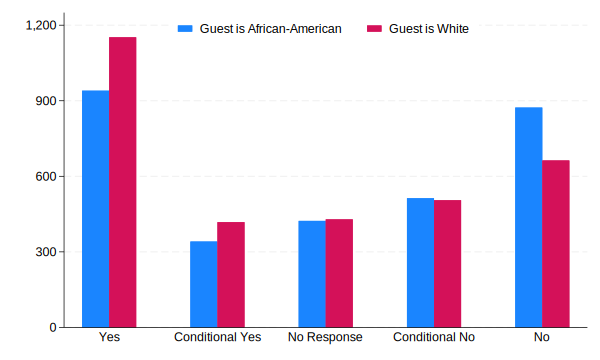




file ./output/figure2.svg saved as SVG format


In [10]:
tab graph_bins,m 

* #delimit ; tells Stata not to consider a line break until we type ;. This can be helpful when typing long commands. 
#delimit ;
graph bar (sum) guest_race_black guest_race_white,
over(graph_bins, gap(200))
legend(label(1 "Guest is African-American") label(2 "Guest is White")) ylabel(0(300)1200, angle(0)) legend(symxsize(*0.5) symysize(*0.5) row(1) pos(12) ring(0));
graph export "./output/figure2.svg", width(1600) fontface("Times New Roman") replace;
#delimit cr

***Commit Changes to GitHub.*** Include a specific commit message that describes your updates.

## Heterogeneity by Host Race/Ethnicity and Sex (Tables 3)

- It could be that the response of hosts to requests from Black guests differs by the underlying characteristics of the host (Table 3).

- Col. 1: to check for heterogeneity, estimate a version of the main model without controls where you add an interaction between the treatment (`guest_race_black`) and an indicator for whether the host is Black (`host_race_black`). Use the `lincom` command to combine regression coefficients (last row of Table 3).

- Col.'s 2-4: Estimate the same model separately for male hosts, female hosts, and hosts where sex is missing, respectively. 

In [11]:
* create interaction
gen guest_host_black = guest_race_black*host_race_black
label var guest_host_black "Guest is African American * Host is African American"

*** col. 1 - all hosts 
di "Col. 1 Regression"
reg yes guest_race_black host_race_black guest_host_black, vce(cluster name_by_city)

***** calc. depvar mean for white guests 
qui sum yes if e(sample) & guest_race_white==1
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

***** combined treatment effect for Black hosts 
lincom guest_race_black + guest_host_black

*** col. 2 - male hosts 
di "Col. 2 Regression"
reg yes guest_race_black host_race_black guest_host_black if host_sex_male==1, vce(cluster name_by_city)

***** calc. depvar mean for white guests 
qui sum yes if e(sample) & guest_race_white==1
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

***** combined treatment effect for Black hosts 
lincom guest_race_black + guest_host_black

*** col. 3 - female hosts 
di "Col. 3 Regression"
reg yes guest_race_black host_race_black guest_host_black if host_sex_female==1, vce(cluster name_by_city)

***** calc. depvar mean for white guests 
qui sum yes if e(sample) & guest_race_white==1
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

***** combined treatment effect for Black hosts 
lincom guest_race_black + guest_host_black

*** col. 4 - other hosts 
di "Col. 4 Regression"
reg yes guest_race_black host_race_black guest_host_black if host_sex_msg==1, vce(cluster name_by_city)

***** calc. depvar mean for white guests 
qui sum yes if e(sample) & guest_race_white==1
local dv_mean = string(round(`r(mean)',0.001), "%6.3f")
di "Mean Response Rate (White Guests): " `dv_mean'

***** combined treatment effect for Black hosts 
lincom guest_race_black + guest_host_black




Col. 1 Regression


Linear regression                               Number of obs     =      6,235
                                                F(3, 103)         =      12.02
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0076
                                                Root MSE          =     .49559

                             (Std. err. adjusted for 104 clusters in name_by_city)
----------------------------------------------------------------------------------
                 |               Robust
             yes | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-----------------+----------------------------------------------------------------
guest_race_black |  -.0801552   .0167794    -4.78   0.000    -.1134333   -.0468772
 host_race_black |   .0617433   .0304304     2.03   0.045     .0013917    .1220949
guest_host_black |   .0065142   .0462595   

### Describe whether you find evidence of a differential response to requests from Black guests by host race or sex. 

- None of the interaction terms are statistically significant. However, the point estimates on the interaction are interesting. It appears Black men are *less* likely to respond positively to a Black guest while Black women are *more* likely to respond positively to a Black guest. Even so, we should not push these results too far as we cannot reject the null that the coefficients on the interaction terms are zero.

***Commit Changes to GitHub.*** Include a specific commit message that describes your updates.

## Finally, write code to calculate the means in Table 4 from the paper. You may want to use a series of nested `foreach` loops. 

In [12]:
* note: have to account for missing responses to replicate results of paper 
qui gen yes_temp = yes
qui replace yes_temp = 0 if missing(yes)

foreach host_sex in host_sex_male host_sex_female {
	foreach host_race in host_race_white host_race_black {
		foreach guest_sex in guest_sex_male guest_sex_female {
			foreach guest_race in guest_race_white guest_race_black {
				di "-----------------------------"
				di "Host: `host_sex' `host_race'"
				di "Guest: `guest_sex' `guest_race'"
                * calculate positive response rate // qui is short for quietly, which suppresses output
				qui proportion yes_temp if `host_sex'==1 & `host_race'==1 & `guest_sex'==1 & `guest_race'==1
                * display key values 
				di "Share Accepted: " r(table)[1,2]
				di "-----------------------------"
			}
		}
	}
}
drop yes_temp 




-----------------------------
Host: host_sex_male host_race_white
Guest: guest_sex_male guest_race_white
Share Accepted: .41666667
-----------------------------
-----------------------------
Host: host_sex_male host_race_white
Guest: guest_sex_male guest_race_black
Share Accepted: .35403727
-----------------------------
-----------------------------
Host: host_sex_male host_race_white
Guest: guest_sex_female guest_race_white
Share Accepted: .48816568
-----------------------------
-----------------------------
Host: host_sex_male host_race_white
Guest: guest_sex_female guest_race_black
Share Accepted: .32485876
-----------------------------
-----------------------------
Host: host_sex_male host_race_black
Guest: guest_sex_male guest_race_white
Share Accepted: .64285714
-----------------------------
-----------------------------
Host: host_sex_male host_race_black
Guest: guest_sex_male guest_race_black
Share Accepted: .40425532
-----------------------------
---------------------------

***Commit Changes to GitHub.*** Include a specific commit message that describes your updates. This is your final commit. Ensure you can see all your changes in your browser. 